# 飞桨领航团第三次作业

## 数据集处理

### 解压

In [ ]:
!unzip -oq /home/aistudio/data/data107275/archive"(5)".zip -d work

### 读取标签

In [1]:
import pandas as pd
category_num = 0
category_max = 0
image_path = "work/images/"
pro_path = "work/images_processed/"
train_path = "work/train/images/"
test_path = "work/test/images/"

#读取标签
labels = pd.read_csv("work/annotations.csv",sep=',',encoding='unicode_escape')

# 获取数据集中交通标志牌的总类别数
for category in labels.loc[:,"category"]:
    if category > category_max:
        category_max = category
print("该数据集中包含总类别数为："+str(category+1))

该数据集中包含总类别数为：58


### cut

In [ ]:
# from PIL import Image
 
# img = Image.open("./data/cut/thor.jpg")
# print(img.size)
# cropped = img.crop((0, 0, 512, 128))  # (left, upper, right, lower)
# cropped.save("./data/cut/pil_cut_thor.jpg")

### pad

In [ ]:
from PIL import Image
import numpy as np
import paddle
import paddle.vision.transforms as T
from PIL import Image



trans = T.Compose([
            T.Normalize(
                # mean= [0.43063927, 0.41976154, 0.42952005],
                # std = [0.20604774, 0.19884101, 0.20074175],
                data_format='HWC'),
                T.ToTensor()
            ])

def pad_image(image, target_size):
 
    """
    :param image: input image
    :param target_size: a tuple (num,num)
    :return: new image
    """
 
    iw, ih = image.size  # 原始图像的尺寸
    w, h = target_size  # 目标图像的尺寸
 
    # print("original size: ",(iw,ih))
    # print("new size: ", (w, h))
 
    scale = min(w / iw, h / ih)  # 转换的最小比例
 
    # 保证长或宽，至少一个符合目标图像的尺寸 0.5保证四舍五入
    nw = int(iw * scale+0.5)
    nh = int(ih * scale+0.5)
 
    # print("now nums are: ", (nw, nh))
 
    image = image.resize((nw, nh), Image.BICUBIC)  # 更改图像尺寸，双立法插值效果很好
    #image.show()
    new_image = Image.new('RGB', target_size, (0, 0, 0))  # 生成黑色图像
    # // 为整数除法，计算图像的位置
    new_image.paste(image, ((w - nw) // 2, (h - nh) // 2))  # 将图像填充为中间图像，两侧为黑色的样式
    #new_image.show()
 
    return new_image


for i in range(len(labels)):
    label = labels['file_name'][i]
    # image = Image.open(image_path + labels['file_name'][i])
    # image_np = np.array(image)
    # image_tensor = paddle.to_tensor(image_np)
    # image_tensor = np.transpose(image_tensor, (2,0,1))
    # print(image)
    # print(image_np)
    # print(image_tensor)
    # image_np = np.array(image_tensor)
    # image = Image.fromarray(uint8(image_np))
    # new_image = pad_image(image, 672)
    # pool3_3 = paddle.nn.MaxPool2D(3, 0)
    # image_tensor = pool3_3(image_tensor)
    # new_image.save(pad_path + label)
    # image_PIL = Image.open(image_path + label).convert('RGB')

    image_PIL = Image.open(image_path + labels['file_name'][i])
    new_image = pad_image(image_PIL, (672,672))

    image_np = np.array(new_image).astype('float32')
    image_tensor = trans(image_np).reshape([1,3,672,672])
    pool3_3 = paddle.nn.MaxPool2D(kernel_size=3, stride=3, padding=0)
    image_tensor = pool3_3(image_tensor)
    image_np = np.array(image_tensor)
    image_np = np.reshape(image_np,(3,224,224))
    image_PIL = Image.fromarray(np.uint8(image_np.transpose(1,2,0)))
    image_PIL.save(pro_path + label)

    

### 分组，5：1分开训练、测试集

In [ ]:
import random
from PIL import Image

# 生成测试集
# 生成1000随机数，测试集的索引
test_list = [random.randint(0,5998) for i in range(1000)]
print(test_list[0:5])
labels_test = labels.iloc[test_list[:],:]
print(labels.iloc[test_list[:],:])
df = labels_test.to_csv('work/test/labels_test.csv')
for image_name in labels_test['file_name']:
    image = Image.open(pro_path + image_name)
    image.save(test_path + image_name)

[5477, 1891, 4885, 3589, 4198]
               file_name  width  height  x1  y1   x2   y2  category
5477  013_1_0019_1_j.png    151     140  41  31  107  101        13
1891        048_0004.png    193     168  35  28  168  133        48
4885      042_0005_j.png    209     201  30  39  162  151        42
3589      024_1_0032.png    142     130  25  10  129  124        24
4198        002_0017.png     42      45   5   5   37   42         2
...                  ...    ...     ...  ..  ..  ...  ...       ...
381         014_0008.png    126     111  20  13  113  101        14
2036        055_0052.png    129     138  26  29  107  110        55
2896      043_1_0005.png    106     106  21  15   97   78        43
2309      005_1_0044.png    124     117  22  16  106  103         5
5998  050_1_0002_1_j.png    107     104  18  21   83   81        50

[1000 rows x 8 columns]


In [ ]:
# 训练集
labels_train = labels.drop(labels.index[test_list])
labels_train.to_csv('work/train/labels_train.csv')
for image_name in labels['file_name']:
    image = Image.open(pro_path + image_name)
    image.save(train_path + image_name)

In [ ]:
labels_train = pd.read_csv("work/train/labels_train.csv")
labels_test = pd.read_csv("work/test/labels_test.csv")
# print(labels_test)
# print(labels_train)

### 读取图片，定义dataset、dataloader

In [ ]:
# 读取图片并与标签组合
import paddle
import numpy as np
import paddle.vision.transforms as T
from PIL import Image
batch_size = 100
# 定义dataset类
class MyImageNetDataset(paddle.io.Dataset):
    def __init__(self,
                 num_samples,
                 num_classes,
                 train=True):
        super(MyImageNetDataset, self).__init__()

        self.num_samples = num_samples
        self.num_classes = num_classes
        self.transform = T.Compose([
            T.Normalize(
                mean= [0.43063927, 0.41976154, 0.42952005],
                std = [0.20604774, 0.19884101, 0.20074175],
                data_format='HWC'),
                T.ToTensor()
            ])
        self.train = train

    def __getitem__(self, index):
        if self.train:
            image = np.array(Image.open(train_path + labels_train['file_name'][index])).astype('float32')/255
        else:
            image = np.array(Image.open(test_path + labels_test['file_name'][index])).astype('float32')/255
        # label = np.zeros([58]).astype("float32")
        # label[int(labels['category'][index])] = 1
        label = labels['category'][index]

        image = self.transform(image)
        return image, label

    def __len__(self):
        return self.num_samples

# dataset对象
train_dataset = MyImageNetDataset(num_samples=5000, num_classes=58, train = True)
test_dataset  = MyImageNetDataset(num_samples=1000, num_classes=58, train = False)
# print(train_dataset.__getitem__(100)[0].shape)
# print(len(train_dataset))

# dataloader
train_dataloader = paddle.io.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        drop_last=False)
test_dataloader  = paddle.io.DataLoader(test_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        drop_last=False)

# test loader
for step, (image, label) in enumerate(train_dataloader()):
    print("step =",step, image.shape, label.numpy())
    if step==1:
        break
for step, (image, label) in enumerate(test_dataloader()):
    print("step =",step, image.shape, label.numpy())
    if step==1:
        break

# print(train_dataset.__getitem__(0))

step = 0 [50, 3, 224, 224] [14  3  3 24  7 52  0 55 12 29 35 35 28 36 11 23 37  7  3 52 28 13 12  5
 54  3 28  1 30 20 26  7  3  1 16 35  6  2  3 14  7  6 13 26 11 28 30  6
 28 56]
step = 1 [50, 3, 224, 224] [54 43 50 16 17 14 10 28  3 16 17 26 55  0 31 16  0 55  2 28  5  5 28  0
  4 30 35 54  4  0  5 44 56 10 11 43 26  4  7  3  3  2 28 20 54 46 27 52
 35 16]
step = 0 [50, 3, 224, 224] [35 49  3 55 12 12 20 36  5 24 29 17  2 31  3 35 31  5 22 51  0 37 35 14
  2 35 54  5 50 29 43 14 34 54 40  0  3 35 43 31 45 38 24  3 12  7 24 11
 54 37]
step = 1 [50, 3, 224, 224] [24 42  3 35 14 35  2 47 28 12 12 55  2  3  5 55 11  3 11  7 40 14 35  2
 54 29 54 26  1  5 37 30 26 37  0  5 14 49 13 40 16  1 24 43  3 29  7  0
  2 43]


全部数据集，不知道为什么，必须用全集才能训练出一定效果

In [ ]:
# 读取图片并与标签组合
import paddle
import numpy as np
import paddle.vision.transforms as T
from PIL import Image
batch_size = 50
labels = pd.read_csv("work/annotations.csv")
# 定义dataset类
class MyImageNetDataset_all(paddle.io.Dataset):
    def __init__(self,
                 num_samples,
                 num_classes):
        super().__init__()

        self.num_samples = num_samples
        self.num_classes = num_classes
        self.transform = T.Compose([
            T.Normalize(
                mean= [0.43063927, 0.41976154, 0.42952005],
                std = [0.20604774, 0.19884101, 0.20074175],
                data_format='HWC'),
                T.ToTensor()
            ])

    def __getitem__(self, index):
        image = np.array(Image.open(pro_path + labels['file_name'][index])).astype('float32')/255
        # label = np.zeros([58]).astype("float32")
        # label[int(labels['category'][index])] = 1
        label = labels['category'][index]

        image = self.transform(image)
        return image, label

    def __len__(self):
        return self.num_samples

# dataset对象
dataset = MyImageNetDataset_all(num_samples=6000, num_classes=58)
dataloader  = paddle.io.DataLoader(dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=False)

## 模型准备

### Alex_net

In [38]:
import paddle.nn as nn
import paddle.nn.functional as F
import numpy as np
from paddle.vision.transforms import Compose, Resize, Transpose, Normalize

#构建模型
class Traffic_Model(nn.Layer):
    def __init__(self):
        super().__init__()
        self.conv_pool1 = paddle.nn.Sequential(  #输入大小m*3*227*227
            paddle.nn.Conv2D(3,96,11,4,0),      #L1, 输出大小m*96*55*55
            paddle.nn.ReLU(),       #L2, 输出大小m*96*55*55
            paddle.nn.MaxPool2D(kernel_size=3, stride=2))  #L3, 输出大小m*96*27*27
        self.conv_pool2 = paddle.nn.Sequential(
            paddle.nn.Conv2D(96, 256, 5, 1, 2), #L4, 输出大小m*256*27*27
            paddle.nn.ReLU(),       #L5, 输出大小m*256*27*27
            paddle.nn.MaxPool2D(3, 2))         #L6, 输出大小m*256*13*13
        self.conv_pool3 = paddle.nn.Sequential(
            paddle.nn.Conv2D(256, 384, 3, 1, 1),#L7, 输出大小m*384*13*13
            paddle.nn.ReLU())       #L8, 输出m*384*13*13
        self.conv_pool4 = paddle.nn.Sequential(
            paddle.nn.Conv2D(384, 384, 3, 1, 1),#L9, 输出大小m*384*13*13
            paddle.nn.ReLU())       #L10, 输出大小m*384*13*13
        self.conv_pool5 = paddle.nn.Sequential(
            paddle.nn.Conv2D(384, 256, 3, 1, 1),#L11, 输出大小m*256*13*13
            paddle.nn.ReLU(),       #L12, 输出大小m*256*13*13
            paddle.nn.MaxPool2D(3, 2))         #L13, 输出大小m*256*6*6
        self.full_conn = paddle.nn.Sequential(
            paddle.nn.Linear(6400, 4096),    #L14, 输出大小m*4096
            paddle.nn.ReLU(),       #L15, 输出大小m*4096
            paddle.nn.Dropout(0.5),             #L16, 输出大小m*4096
            paddle.nn.Linear(4096, 4096),       #L17, 输出大小m*4096
            paddle.nn.ReLU(),       #L18, 输出大小m*4096
            paddle.nn.Dropout(0.5),             #L19, 输出大小m*4096
            paddle.nn.Linear(4096, 58))        #L20, 输出大小m*
        self.flatten=paddle.nn.Flatten()

    def forward(self, x): #前向传播
        x = self.conv_pool1(x)
        x = self.conv_pool2(x)
        x = self.conv_pool3(x)
        x = self.conv_pool4(x)
        x = self.conv_pool5(x)
        x = self.flatten(x)
        # x = F.softmax()
        x = self.full_conn(x)
        x = paddle.reshape(x, [58,1])
        return x

### VGG

In [ ]:
# VGG模型代码
import numpy as np
import paddle
import paddle.fluid as fluid
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, BatchNorm, Linear
from paddle.fluid.dygraph.base import to_variable

# 定义vgg块，包含多层卷积和1层2x2的最大池化层
class vgg_block(fluid.dygraph.Layer):
    def __init__(self, num_convs, in_channels, out_channels):
        """
        num_convs, 卷积层的数目
        num_channels, 卷积层的输出通道数，在同一个Incepition块内，卷积层输出通道数是一样的
        """
        super(vgg_block, self).__init__()
        self.conv_list = []
        for i in range(num_convs):
            conv_layer = self.add_sublayer('conv_' + str(i), Conv2D(num_channels=in_channels, 
                                        num_filters=out_channels, filter_size=3, padding=1, act='relu'))
            self.conv_list.append(conv_layer)
            in_channels = out_channels
        self.pool = Pool2D(pool_stride=2, pool_size = 2, pool_type='max')
    def forward(self, x):
        for item in self.conv_list:
            x = item(x)
        return self.pool(x)

class VGG(fluid.dygraph.Layer):
    def __init__(self, conv_arch=((2, 64), 
                                (2, 128), (3, 256), (3, 512), (3, 512))):
        super(VGG, self).__init__()
        self.vgg_blocks=[]
        iter_id = 0
        # 添加vgg_block
        # 这里一共5个vgg_block，每个block里面的卷积层数目和输出通道数由conv_arch指定
        in_channels = [3, 64, 128, 256, 512, 512]
        for (num_convs, num_channels) in conv_arch:
            block = self.add_sublayer('block_' + str(iter_id), 
                    vgg_block(num_convs, in_channels=in_channels[iter_id], 
                              out_channels=num_channels))
            self.vgg_blocks.append(block)
            iter_id += 1
        self.fc1 = Linear(input_dim=512*7*7, output_dim=4096,
                      act='relu')
        self.drop1_ratio = 0.5
        self.fc2= Linear(input_dim=4096, output_dim=4096,
                      act='relu')
        self.drop2_ratio = 0.5
        self.fc3 = Linear(input_dim=4096, output_dim=58)
        
    def forward(self, x):
        for item in self.vgg_blocks:
            x = item(x)
        x = fluid.layers.reshape(x, [x.shape[0], -1])
        x = fluid.layers.dropout(self.fc1(x), self.drop1_ratio)
        x = fluid.layers.dropout(self.fc2(x), self.drop2_ratio)
        x = self.fc3(x)
        return x

## 模型训练
* lr_schedule-----0.001
* optimize--------Adam、SGD
* epoch-----------10
* batch_size------100
* Loss function---CrossEntropy

训练结束后保存网络和优化器的state_dict()参数

In [ ]:
print(paddle.get_device())
# paddle.set_device('gpu')

gpu:0


### paddle.Model

In [ ]:
model=paddle.Model(Traffic_Model())

model.prepare(paddle.optimizer.Adam(parameters=model.parameters()),
              paddle.nn.CrossEntropyLoss(),
              paddle.metric.Accuracy())

model.fit(train_dataset,
          epochs=5,
          batch_size=64,
          verbose=1
          )


### 传统方法

#### 1-1

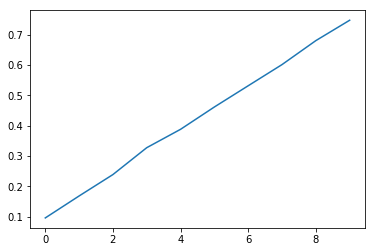

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/framework/io.py:729: UserWarning: The input state dict is empty, no need to save.
  warnings.warn("The input state dict is empty, no need to save.")


In [39]:
import paddle.nn as nn
import paddle.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
model = VGG()

# model = Traffic_Model()
# model.train()
# for step, (image, label) in enumerate(train_dataloader()):
#     print(image.shape)
#     print(model(image))
#     print(label)
#     break

epoch_num = 10
learning_rate = 0.001


opt = paddle.optimizer.SGD(learning_rate=learning_rate, parameters=model.parameters())
# Loss = nn.CrossEntropyLoss()
correct = 0
acc = 0
acc_list = []
epoch_list = []
def train(model):
    #启动训练模式
    model.train()

    for epoch in range(epoch_num):
        acc_avg = 0
        for batch_id, data in enumerate(dataloader()):
            x_data = paddle.cast(data[0], 'float32')
            y_data = paddle.cast(data[1], 'int64')
            y_data = paddle.reshape(y_data, (-1, 1))
            y_predict = model(x_data)
            loss = F.cross_entropy(y_predict, y_data)
            # loss = Loss(y_predict, y_data)
            loss.backward()
            opt.step()
            opt.clear_grad()
            acc = float(np.asarray(paddle.metric.accuracy(y_predict, y_data))[0])
            acc_avg += acc
            # print(batch_id, '-th batch', 'acc:', '%.2f'%acc, 'loss:', np.asarray(loss)[0])
            print(batch_id, '-th batch', 'acc:', '%.2f'%acc)
        acc_avg /= int(5000/batch_size)
        epoch_list.append(epoch)
        acc_list.append(acc_avg)
        print("训练轮次: {}; 损失: {};平均准确率：{:.4f}".format(epoch, loss.numpy(), acc_avg))

train(model)
plt.plot(epoch_list, acc_list)
plt.show()
paddle.save(model.state_dict(), 'work/model1.pdparams')
paddle.save(opt.state_dict(), 'work/opt1.pdopt')

#### 1-2
上面epoch设置得有点小，再跑一次

计算平均acc时，分母应该是60，写成50了，所以会有超过1的现象，但是每个batch的准确率没有问题

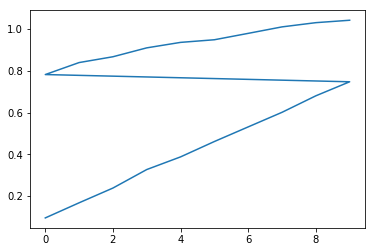

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/framework/io.py:729: UserWarning: The input state dict is empty, no need to save.
  warnings.warn("The input state dict is empty, no need to save.")


In [40]:
train(model)
plt.plot(epoch_list, acc_list)
plt.show()
paddle.save(model.state_dict(), 'work/model1.pdparams')
paddle.save(opt.state_dict(), 'work/opt1.pdopt')

In [ ]:
import paddle.nn as nn
import paddle.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
model = VGG()

epoch_num = 10
learning_rate = 0.001


opt = paddle.optimizer.SGD(learning_rate=learning_rate, parameters=model.parameters())
# Loss = nn.CrossEntropyLoss()
correct = 0
acc = 0
acc_list = []
epoch_list = []
def train(model):
    #启动训练模式
    model.train()

    for epoch in range(epoch_num):
        acc_avg = 0
        for batch_id, data in enumerate(dataloader()):
            x_data = paddle.cast(data[0], 'float32')
            y_data = paddle.cast(data[1], 'int64')
            y_data = paddle.reshape(y_data, (-1, 1))
            y_predict = model(x_data)
            loss = F.cross_entropy(y_predict, y_data)
            # loss = Loss(y_predict, y_data)
            loss.backward()
            opt.step()
            opt.clear_grad()
            acc = float(np.asarray(paddle.metric.accuracy(y_predict, y_data))[0])
            acc_avg += acc
            # print(batch_id, '-th batch', 'acc:', '%.2f'%acc, 'loss:', np.asarray(loss)[0])
            print(batch_id, '-th batch', 'acc:', '%.2f'%acc)
        acc_avg /= int(5000/batch_size)
        epoch_list.append(epoch)
        acc_list.append(acc_avg)
        print("训练轮次: {}; 损失: {};平均准确率：{:.4f}".format(epoch, loss.numpy(), acc_avg))

train(model)
plt.plot(epoch_list, acc_list)
plt.show()
paddle.save(model.state_dict(), 'work/model2.pdparams')
paddle.save(opt.state_dict(), 'work/opt2.pdopt')

## 测试模型
### 参数导入
paddle.load函数导入网络layer及优化器opt的参数

In [41]:
# load
layer_state_dict = paddle.load("work/model1.pdparams")
opt_state_dict = paddle.load("work/opt1.pdopt")

model.set_state_dict(layer_state_dict)
opt.set_state_dict(opt_state_dict)
print(opt)

### 测试准确率

In [42]:
model.eval()
accuracies = []
losses = []
for batch_id, data in enumerate(test_dataloader()):
    x_data = paddle.cast(data[0], 'float32')
    y_data = paddle.cast(data[1], 'int64')
    y_data = paddle.reshape(y_data, (-1, 1))
    y_predict = model(x_data)
    loss = F.cross_entropy(y_predict, y_data)
    acc = paddle.metric.accuracy(y_predict, y_data)
    accuracies.append(np.mean(acc.numpy()))
    losses.append(np.mean(loss.numpy()))

avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
print("评估准确度为：{}；损失为：{}".format(avg_acc, avg_loss))
val_acc_history.append(avg_acc)
val_loss_history.append(avg_loss)

评估准确度为：0.034999996423721313；损失为：13.963948249816895


以下请忽略~学习框架时的一些测试

In [ ]:
# 以下为测试交叉熵损失函数
import paddle

input_data = paddle.rand(shape=[5, 100])
label_data = paddle.randint(0, 100, shape=[5,1], dtype="int64")
weight_data = paddle.rand([100])
# print(input_data)

loss = paddle.nn.functional.cross_entropy(input=input_data, label=label_data, weight=weight_data)
print(loss)
# [4.38418674]


Tensor(shape=[1], dtype=float32, place=CPUPlace, stop_gradient=True,
       [4.64138317])


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:253: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.bool, the right dtype will convert to paddle.float32
  format(lhs_dtype, rhs_dtype, lhs_dtype))


In [ ]:
# 交叉熵损失
import paddle
import numpy as np

input_data = paddle.uniform([5, 100], dtype="float64")
label_data = np.random.randint(0, 100, size=(5)).astype(np.int64)
weight_data = np.random.random([100]).astype("float64")
# print(input_data)
input =  paddle.to_tensor(input_data)
label =  paddle.to_tensor(label_data)
weight = paddle.to_tensor(weight_data)

ce_loss = paddle.nn.CrossEntropyLoss(weight=weight, reduction='mean')
output = ce_loss(input, label)
print(output)
# [4.84496039]



Tensor(shape=[1], dtype=float64, place=CPUPlace, stop_gradient=True,
       [4.95495153])


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:253: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float64, but right dtype is paddle.bool, the right dtype will convert to paddle.float64
  format(lhs_dtype, rhs_dtype, lhs_dtype))


以下为默认提示

In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 